<a href="https://colab.research.google.com/github/yasirgunes/wind_power_estimation/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary libraries and implement preprocessing**
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os # for path manipulation
import sys # for path manipulation
from sklearn.preprocessing import StandardScaler

In [ ]:
sys.path.append('drive/MyDrive/Wind Power Estimation')
from data_analysis import implement_data_preprocessing

In [ ]:
aliaga_data, camlica_data, bursa_data, balikesir_data = implement_data_preprocessing()

**Visualize the wind power data**
---



<Axes: xlabel='date'>

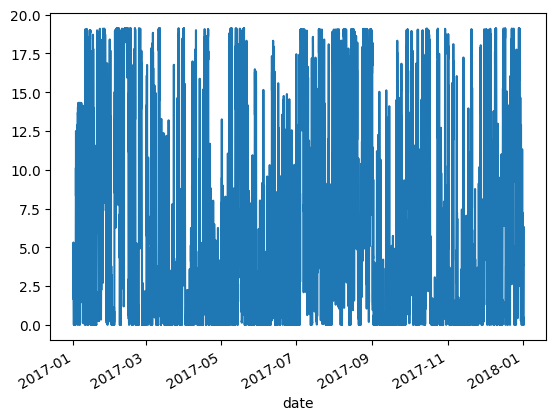

In [ ]:
wind_data = aliaga_data["wind"][:"20180101"]
wind_data.plot()

In [ ]:
aliaga_data.head()

,wind,ws10m,wd10m,ws50m,wd50m,rh2m,ps,prectotcorr,t2m,t2mdew,t2mwet,u10,v10,u50,v50
date,,,,,,,,,,,,,,,
2017-01-01 00:00:00,4.23,2.10,52.57,3.95,52.00,100.00,98.41,0.0,-5.10,-4.78,-4.94,1.276363,1.667603,2.431863,3.112642
2017-01-01 01:00:00,3.37,2.07,63.05,3.77,62.48,100.00,98.39,0.0,-4.84,-5.06,-4.95,0.938150,1.845203,1.741959,3.343423
2017-01-01 02:00:00,5.15,2.73,69.90,3.59,69.63,97.00,98.39,0.0,-4.47,-5.27,-4.87,0.938191,2.563727,1.249612,3.365497
2017-01-01 03:00:00,1.68,2.79,72.93,3.50,72.86,94.44,98.37,0.0,-4.35,-5.48,-4.92,0.818976,2.667092,1.031476,3.344556
2017-01-01 04:00:00,1.72,2.86,73.84,3.59,73.97,92.94,98.34,0.0,-4.35,-5.66,-5.00,0.795997,2.746996,0.991345,3.450411


**Setup the model**
---
- It will use sliding window approach
- It will for example take 5 hour input one by one and then predict the 6th hour.
- The model will be trained this way. It may take 24 hour as input and can predict the 1 hour later. It will be tentative.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

In [ ]:
class WindPowerSequence(Sequence):
    """
    A memory-efficient sequence generator for wind power data.
    Instead of loading all sequences into memory at once, this generator
    creates them on-the-fly as needed during training.
    """
    def __init__(self, data, input_window, prediction_horizon, batch_size=32):
        self.data = data
        self.input_window = input_window
        self.prediction_horizon = prediction_horizon
        self.batch_size = batch_size

        # Calculate the total number of possible sequences
        self.n_sequences = len(data) - input_window - prediction_horizon + 1

        # Get feature names (all columns except 'wind' which is our target)
        self.feature_names = [col for col in data.columns if col != 'wind']

    def __len__(self):
        """Return the number of batches per epoch"""
        return int(np.ceil(self.n_sequences / self.batch_size))

    def __getitem__(self, idx):
        """Generate one batch of data"""
        # Calculate batch start and end indices
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, self.n_sequences)

        # Initialize batch arrays
        batch_size = batch_end - batch_start
        X_batch = np.zeros((batch_size, self.input_window, len(self.feature_names)))
        y_batch = np.zeros(batch_size)

        # Fill the batch arrays
        for i in range(batch_size):
            sequence_start = batch_start + i
            sequence_end = sequence_start + self.input_window

            # Get input sequence
            X_batch[i] = self.data[self.feature_names].iloc[sequence_start:sequence_end].values

            # Get target value
            target_idx = sequence_end + self.prediction_horizon - 1
            y_batch[i] = self.data['wind'].iloc[target_idx]

        return X_batch, y_batch

def prepare_data_for_training(data, input_window, prediction_horizon, batch_size=32, train_split=0.8):
    """
    Prepares and scales the data for training the wind power prediction model.

    This function handles several crucial preprocessing steps:
    1. Splits the data into training and validation sets
    2. Scales both features and target variables independently
    3. Creates sequence generators for both datasets

    The scaling is done separately for features and target to maintain proper scaling
    relationships and make it easier to inverse transform predictions later.

    Parameters:
    -----------
    data : pd.DataFrame
        The input dataset containing both features and wind power target
    input_window : int
        Number of time steps to use as input for prediction
    prediction_horizon : int
        How many hours ahead to predict
    batch_size : int
        Number of samples per batch for training
    train_split : float
        Proportion of data to use for training (0 to 1)

    Returns:
    --------
    train_gen : WindPowerSequence
        Generator for training data sequences
    val_gen : WindPowerSequence
        Generator for validation data sequences
    target_scaler : StandardScaler
        Fitted scaler for the target variable, needed for inverse transforming predictions
    """
    # Split the data temporally to maintain time series integrity
    split_idx = int(len(data) * train_split)
    train_data = data.iloc[:split_idx].copy()
    val_data = data.iloc[split_idx:].copy()

    # Create and fit scalers for features and target separately
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    # Scale features while preserving column names
    feature_names = [col for col in data.columns if col != 'wind']
    train_data[feature_names] = feature_scaler.fit_transform(train_data[feature_names])
    val_data[feature_names] = feature_scaler.transform(val_data[feature_names])

    # Scale target variable (wind power)
    train_data['wind'] = target_scaler.fit_transform(train_data[['wind']])
    val_data['wind'] = target_scaler.transform(val_data[['wind']])

    # Create sequence generators for training and validation
    train_gen = WindPowerSequence(train_data, input_window, prediction_horizon, batch_size)
    val_gen = WindPowerSequence(val_data, input_window, prediction_horizon, batch_size)

    return train_gen, val_gen, target_scaler

**Expanding Window Approach**
---



In [ ]:
class ExpandingWindowSequence(Sequence):
    """
    An advanced sequence generator that implements expanding window validation.
    This generator starts with a base window of data and gradually expands it
    during training, allowing the model to learn from increasingly more data
    patterns over time.

    The expansion happens by increasing the validation window size after each
    epoch, giving the model access to more diverse scenarios as training progresses.
    """
    def __init__(self, data, input_window, prediction_horizon, batch_size=32,
                 initial_window_size=None, expansion_rate=0.1):
        """
        Initialize the expanding window sequence generator.

        Parameters:
        -----------
        data : pd.DataFrame
            The complete dataset
        input_window : int
            Number of time steps to use as input
        prediction_horizon : int
            How many steps ahead to predict
        batch_size : int
            Size of each batch
        initial_window_size : int
            Size of the initial validation window (in data points)
        expansion_rate : float
            Rate at which to expand the window after each epoch
        """
        self.data = data
        self.input_window = input_window
        self.prediction_horizon = prediction_horizon
        self.batch_size = batch_size

        # Initialize window parameters
        self.initial_window_size = (initial_window_size if initial_window_size
                                  else len(data) // 4)  # Start with 25% of data
        self.current_window_size = self.initial_window_size
        self.expansion_rate = expansion_rate

        # Calculate sequences based on current window
        self.update_sequences()

        # Get feature names (all columns except target)
        self.feature_names = [col for col in data.columns if col != 'wind']

    def update_sequences(self):
        """Update the number of sequences based on current window size"""
        self.n_sequences = min(
            self.current_window_size - self.input_window - self.prediction_horizon + 1,
            len(self.data) - self.input_window - self.prediction_horizon + 1
        )

    def expand_window(self):
        """Expand the window size for the next epoch"""
        expansion_size = int(self.initial_window_size * self.expansion_rate)
        self.current_window_size = min(
            self.current_window_size + expansion_size,
            len(self.data)
        )
        self.update_sequences()

    def __len__(self):
        """Return the number of batches per epoch"""
        return int(np.ceil(self.n_sequences / self.batch_size))

    def __getitem__(self, idx):
        """Generate one batch of data"""
        batch_start = idx * self.batch_size
        batch_end = min((idx + 1) * self.batch_size, self.n_sequences)

        batch_size = batch_end - batch_start
        X_batch = np.zeros((batch_size, self.input_window, len(self.feature_names)))
        y_batch = np.zeros(batch_size)

        for i in range(batch_size):
            sequence_start = batch_start + i
            sequence_end = sequence_start + self.input_window

            X_batch[i] = self.data[self.feature_names].iloc[sequence_start:sequence_end].values

            target_idx = sequence_end + self.prediction_horizon - 1
            y_batch[i] = self.data['wind'].iloc[target_idx]

        return X_batch, y_batch

class ExpandingWindowCallback(tf.keras.callbacks.Callback):
    """
    Custom callback to handle the expansion of the validation window after each epoch.
    This callback works with the ExpandingWindowSequence to gradually increase
    the amount of validation data available during training.
    """
    def __init__(self, val_sequence):
        super().__init__()
        self.val_sequence = val_sequence

    def on_epoch_end(self, epoch, logs=None):
        """Expand the validation window after each epoch"""
        self.val_sequence.expand_window()
        print(f"\nValidation window size expanded to: {self.val_sequence.current_window_size}")

def prepare_data_for_expanding_window(data, input_window, prediction_horizon,
                                    initial_window_size=None, batch_size=32):
    """
    Prepares data for expanding window validation as described in the paper.

    Parameters:
    -----------
    data : pd.DataFrame
        Input data containing features and wind power
    input_window : int
        Number of time steps for input sequence (paper uses 8 hours)
    prediction_horizon : int
        How many hours ahead to predict (paper uses 1 hour)
    initial_window_size : int
        Size of initial training window (paper suggests starting with 25% of data)
    batch_size : int
        Batch size for training
    """
    # Scale the data first
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    feature_names = [col for col in data.columns if col != 'wind']
    scaled_features = feature_scaler.fit_transform(data[feature_names])
    scaled_target = target_scaler.fit_transform(data[['wind']])

    # Create scaled dataframe
    scaled_data = pd.DataFrame(scaled_features, columns=feature_names)
    scaled_data['wind'] = scaled_target

    if initial_window_size is None:
        initial_window_size = len(data) // 4  # Start with 25% as suggested

    return ExpandingWindowSequence(
        scaled_data,
        input_window=input_window,
        prediction_horizon=prediction_horizon,
        batch_size=batch_size,
        initial_window_size=initial_window_size
    ), target_scaler

def train_with_expanding_window(model, data_sequence, epochs=100):
    """
    Trains the model using expanding window validation as per the paper.
    """
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
        ExpandingWindowCallback(data_sequence)
    ]

    history = model.fit(
        data_sequence,
        validation_data=data_sequence,  # Same sequence for validation
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

In [ ]:
# # Your data loading code here
# input_window = 8
# prediction_horizon = 1
# batch_size = 32

# # Create generators with the updated prepare_data_for_training function
# train_gen, val_gen, target_scaler = prepare_data_for_training(
#     aliaga_data,
#     input_window=input_window,
#     prediction_horizon=prediction_horizon,
#     batch_size=batch_size
# )

# # Create expanding window sequence
# data_sequence, target_scaler = prepare_data_for_expanding_window(
#     aliaga_data,
#     input_window=input_window,
#     prediction_horizon=prediction_horizon,
#     batch_size=batch_size
# )

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tensorflow.keras.layers import Bidirectional
def build_encoder_decoder_model(input_shape):
    """
    Creates an advanced bidirectional LSTM model for wind power prediction.

    This model implements a sophisticated architecture using Bidirectional LSTM layers,
    which process sequences both forward and backward. This bidirectional approach
    allows the model to capture temporal patterns that might be missed when only
    processing in one direction, which is particularly valuable for wind power
    prediction where both leading and trailing weather patterns matter.

    The architecture includes:
    1. Two Bidirectional LSTM layers for deep feature extraction
    2. Batch normalization for training stability
    3. Dropout layers for preventing overfitting
    4. Dense layers for final prediction refinement

    Parameters:
    -----------
    input_shape : tuple
        Shape of input data in format (time_steps, features)
        Example: (48, 10) for 48 hours of historical data with 10 features

    Returns:
    --------
    model : tf.keras.Model
        Compiled bidirectional LSTM model ready for training

    Architecture Details:
    -------------------
    - First Bidirectional LSTM: 128 units (64 in each direction)
        Processes the input sequence in both directions to capture temporal dependencies

    - Second Bidirectional LSTM: 64 units (32 in each direction)
        Refines the features extracted by the first layer

    - Batch Normalization: After each LSTM layer
        Normalizes layer outputs to stabilize training and reduce internal covariate shift

    - Dropout (0.2): After each batch normalization
        Randomly deactivates 20% of units during training to prevent overfitting

    - Dense Layers: Final prediction refinement
        Converts processed features into wind power predictions

    Notes:
    ------
    - The model uses 'tanh' activation in LSTM layers (default) which is suitable
      for capturing both positive and negative patterns in wind power changes
    - ReLU activation in dense layers helps capture non-linear relationships
    - Learning rate is set to 0.001 for stable training
    """
    model = Sequential([
        # First Bidirectional LSTM layer with batch normalization
        Bidirectional(LSTM(128, return_sequences=True),
                     input_shape=input_shape,
                     name='bidirectional_lstm_1'),
        BatchNormalization(name='batch_norm_1'),
        Dropout(0.2, name='dropout_1'),

        # Second Bidirectional LSTM layer for deeper feature extraction
        Bidirectional(LSTM(64), name='bidirectional_lstm_2'),
        BatchNormalization(name='batch_norm_2'),
        Dropout(0.2, name='dropout_2'),

        # Dense layers for prediction refinement
        Dense(32, activation='relu', name='dense_1'),
        Dense(1, name='output')
    ])

    # Configure optimizer with reduced learning rate for stability
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Compile model with mean squared error loss and mean absolute error metric
    model.compile(
        optimizer=optimizer,
        loss='mse',  # Mean Squared Error for regression
        metrics=['mae']  # Mean Absolute Error for interpretability
    )

    return model

def create_callbacks(model_name='wind_power_model'):
    """
    Creates callbacks for model training with the correct file extension for newer Keras versions.
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        f'{model_name}_best.keras',  # Changed from .h5 to .keras
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    return [early_stopping, model_checkpoint]

def train_model(model, train_gen, val_gen, epochs=100):
    """
    Trains the model and returns training history.

    Parameters:
    -----------
    model : tf.keras.Model
        The compiled model to train
    train_gen : WindPowerSequence
        Training data generator
    val_gen : WindPowerSequence
        Validation data generator
    epochs : int
        Number of training epochs

    Returns:
    --------
    history : tf.keras.callbacks.History
        Training history
    """
    callbacks = create_callbacks()
    # callbacks.append(ExpandingWindowCallback(val_gen))

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

def plot_training_history(history):
    """
    Plots the training and validation loss over epochs.

    Parameters:
    -----------
    history : tf.keras.callbacks.History
        Training history returned by model.fit()
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# # Get the input shape for the model
# sample_batch = next(iter(train_gen))
# input_shape = sample_batch[0].shape[1:]  # (time_steps, features)

# # Build the model with the updated architecture
# model = build_encoder_decoder_model(input_shape)
# print("\nModel Summary:")
# model.summary()

# # # Train the model as before
# # print("\nStarting model training...")
# # history = train_model(model, train_gen, val_gen, epochs=100)

# # Train the model
# history = train_with_expanding_window(model, data_sequence)

# # Plot training history
# plot_training_history(history)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_model_performance(model, val_gen, target_scaler, num_samples=None):
    """
    Evaluates the model's performance using multiple metrics and visualization.

    This function:
    1. Collects predictions and actual values from the validation generator
    2. Calculates R², RMSE, MSE, and MAE
    3. Creates visualization of predicted vs actual values
    4. Prints a detailed performance report

    Parameters:
    -----------
    model : tf.keras.Model
        The trained model to evaluate
    val_gen : WindPowerSequence
        Validation data generator
    num_samples : int, optional
        Number of samples to evaluate (defaults to entire validation set)

    Returns:
    --------
    dict
        Dictionary containing all computed metrics
    """
    # Collect predictions and actual values
    true_values = []
    predictions = []

    # If num_samples not specified, use all available samples
    if num_samples is None:
        num_samples = len(val_gen) * val_gen.batch_size

    samples_collected = 0

    # Collect predictions batch by batch
    for i in range(len(val_gen)):
        if samples_collected >= num_samples:
            break

        X_batch, y_batch = val_gen[i]
        batch_predictions = model.predict(X_batch, verbose=0)

        true_values.extend(y_batch)
        predictions.extend(batch_predictions.flatten())

        samples_collected += len(y_batch)

    # Convert lists to numpy arrays first
    true_values = np.array(true_values)
    predictions = np.array(predictions)

    # Now we can reshape and inverse transform
    true_values = target_scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Calculate metrics
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)

    # Create visualizations
    plt.figure(figsize=(15, 5))

    # Time series plot
    plt.subplot(1, 2, 1)
    plt.plot(true_values, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Wind Power')
    plt.xlabel('Time Step')
    plt.ylabel('Wind Power')
    plt.legend()

    # Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(true_values, predictions, alpha=0.5)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()],
             'r--', label='Perfect Prediction')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Wind Power')
    plt.ylabel('Predicted Wind Power')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed report
    print("\nModel Performance Metrics:")
    print("-------------------------")
    print(f"R² Score: {r2:.4f} {'✓' if r2 > 0.7 else '✗'} (Target: > 0.7)")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    if r2 > 0.7:
        print("\n✓ Model meets the R² requirement (> 0.7)")
    else:
        print("\n✗ Model does not meet the R² requirement (> 0.7)")
        print("Consider applying some improvements:")
        print("1. Increase the input window size")
        print("2. Add batch normalization")
        print("3. Adjust the model architecture")
        print("4. Feature selection/engineering")

    return {
        'r2': r2,
        'rmse': rmse,
        'mse': mse,
        'mae': mae,
        'predictions': predictions,
        'true_values': true_values
    }

In [ ]:
def evaluate_on_other_windfarm(model, test_data, input_window=8, prediction_horizon=1, batch_size=32):
    """
    Evaluates the trained model on a different wind farm's data, following the paper's methodology.

    This function implements the evaluation approach described in the paper where they test
    the model trained on one wind farm against data from other wind farms to verify
    generalization capability.

    Parameters:
    -----------
    model : tf.keras.Model
        The trained model to evaluate
    test_data : pd.DataFrame
        Data from another wind farm for testing
    input_window : int
        Number of time steps to use as input (8 hours as per paper)
    prediction_horizon : int
        How many hours ahead to predict (1 hour as per paper)
    batch_size : int
        Batch size for evaluation

    Returns:
    --------
    dict
        Dictionary containing performance metrics and predictions
    """
    # Scale the test data independently
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    # Prepare features and target
    feature_names = [col for col in test_data.columns if col != 'wind']
    scaled_features = feature_scaler.fit_transform(test_data[feature_names])
    scaled_target = target_scaler.fit_transform(test_data[['wind']])

    # Create scaled dataframe
    scaled_data = pd.DataFrame(scaled_features, columns=feature_names)
    scaled_data['wind'] = scaled_target

    # Create test sequence
    test_sequence = WindPowerSequence(
        scaled_data,
        input_window=input_window,
        prediction_horizon=prediction_horizon,
        batch_size=batch_size
    )

    # Collect predictions and actual values
    true_values = []
    predictions = []

    for i in range(len(test_sequence)):
        X_batch, y_batch = test_sequence[i]
        batch_predictions = model.predict(X_batch, verbose=0)

        true_values.extend(y_batch)
        predictions.extend(batch_predictions.flatten())

    # Convert to arrays and inverse transform
    true_values = np.array(true_values)
    predictions = np.array(predictions)

    true_values = target_scaler.inverse_transform(true_values.reshape(-1, 1)).flatten()
    predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Calculate metrics
    r2 = r2_score(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)

    # Visualize results
    plt.figure(figsize=(15, 5))

    # Time series plot
    plt.subplot(1, 2, 1)
    plt.plot(true_values[:1000], label='Actual', alpha=0.7)
    plt.plot(predictions[:1000], label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Wind Power (First 1000 samples)')
    plt.xlabel('Time Step')
    plt.ylabel('Wind Power')
    plt.legend()

    # Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(true_values, predictions, alpha=0.1)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()],
             'r--', label='Perfect Prediction')
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Wind Power')
    plt.ylabel('Predicted Wind Power')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"\nModel Performance on Test Wind Farm:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MSE: {mse:.4f}")

    return {
        'r2': r2,
        'rmse': rmse,
        'mse': mse,
        'predictions': predictions,
        'true_values': true_values
    }

Stage 1: Training on Aliaga Wind Farm


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1624 - mae: 0.8291
Validation window size expanded to: 14619
416/416 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - loss: 1.1609 - mae: 0.8285 - val_loss: 0.6246 - val_mae: 0.5898
Epoch 2/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4970 - mae: 0.5451
Validation window size expanded to: 15948
416/416 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - loss: 0.4970 - mae: 0.5452 - val_loss: 0.6953 - val_mae: 0.6461
Epoch 3/100
416/416 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4269 - mae: 0.5010
Validation window size expanded to: 17277
416/416 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - loss: 0.4269 - mae: 0.5010 - val_loss: 0.5443 - val_mae: 0.5799
Epoch 4/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4033 - mae: 0.4797
Validation window size expanded to: 18606
416/416 ━━━━━━━━━━━━━━━━━━━━ 30s 70ms/step - loss: 0.4034 - mae: 0.4798 - val_loss: 0.4877 - val_mae: 0.5320
Epoch 5/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3858 - mae: 

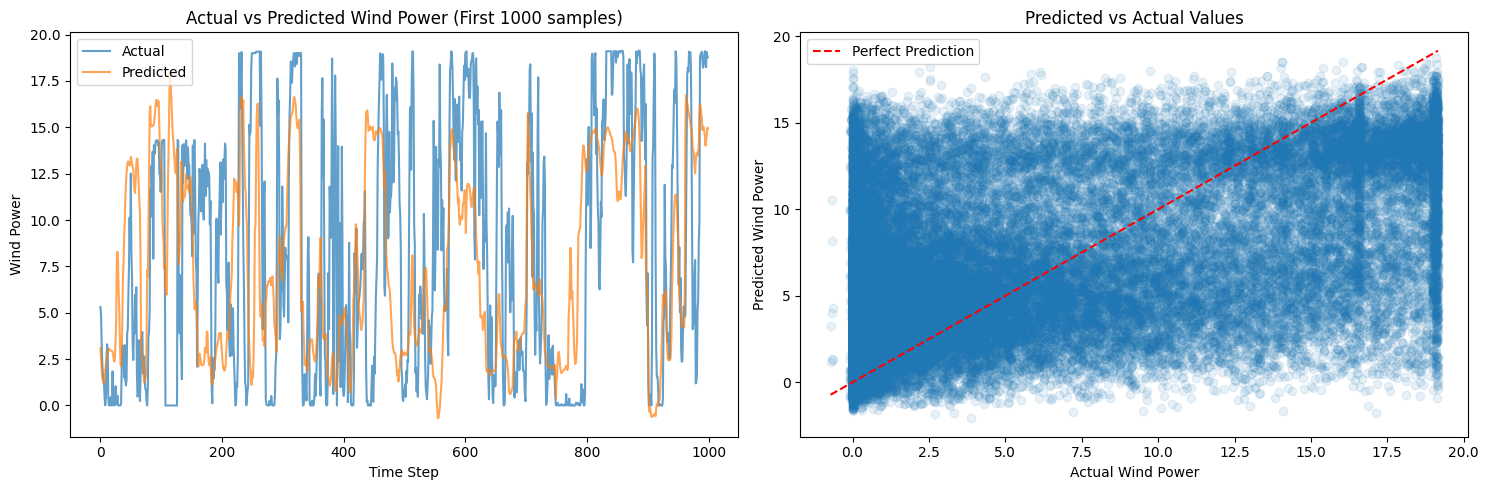


Model Performance on Test Wind Farm:
R² Score: 0.2028
RMSE: 5.7380
MSE: 32.9244

Testing on Camlica Wind Farm:


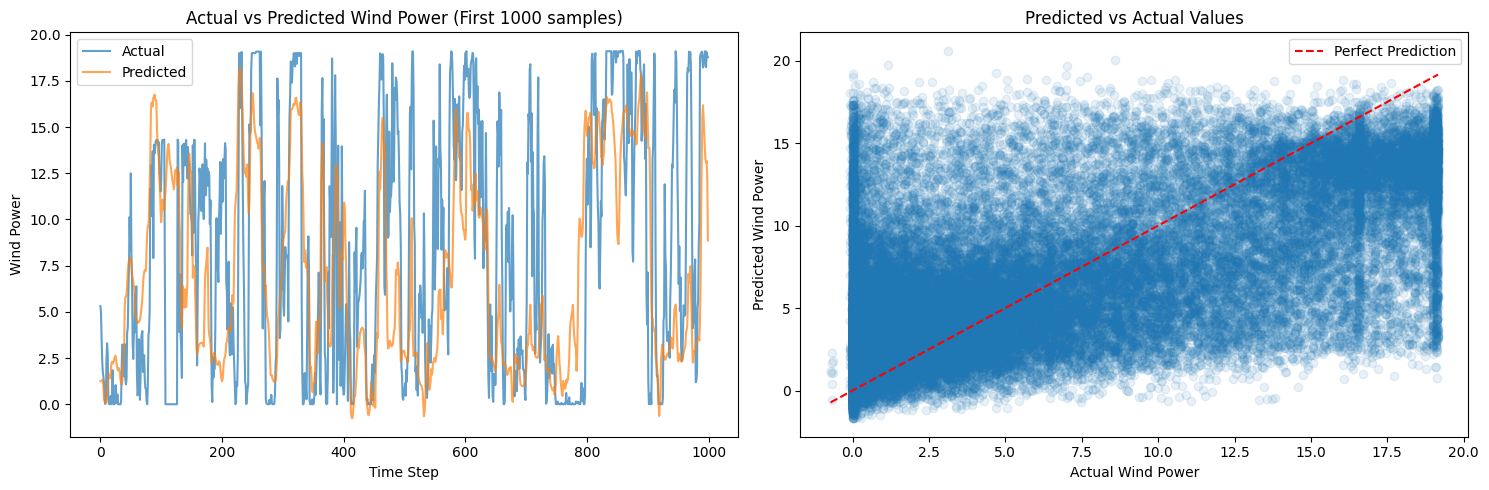


Model Performance on Test Wind Farm:
R² Score: 0.4396
RMSE: 4.8107
MSE: 23.1427

Stage 3: Testing on Newly-established Wind Farm (Bursa)


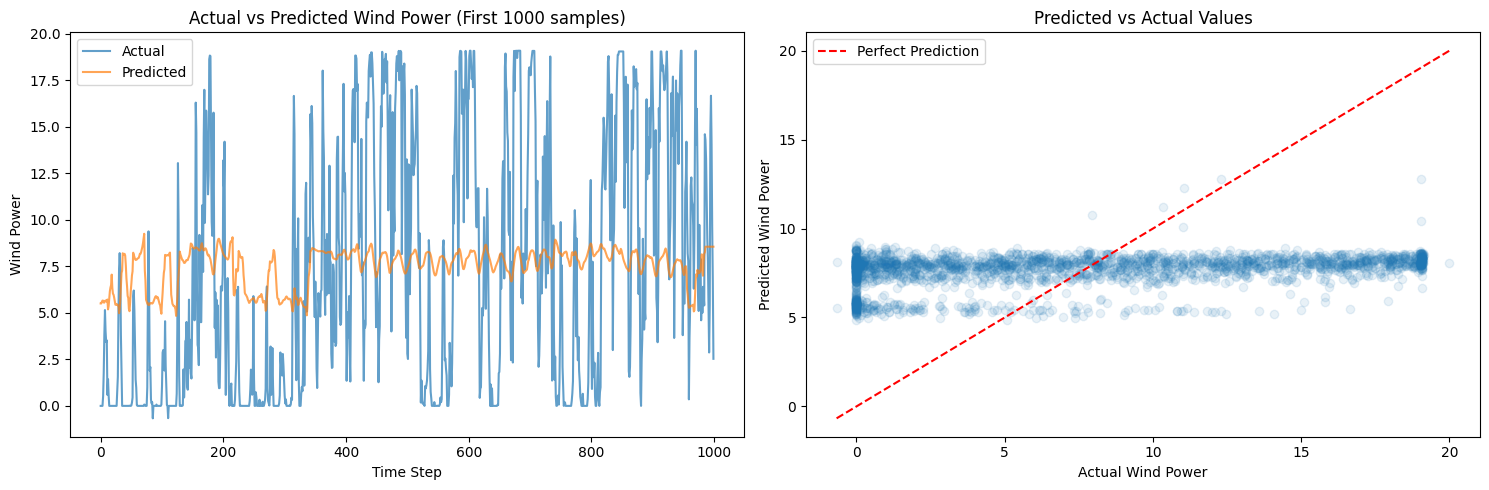


Model Performance on Test Wind Farm:
R² Score: 0.0651
RMSE: 6.2496
MSE: 39.0576


In [ ]:
def complete_wind_power_evaluation():
    """
    Implements the complete three-stage evaluation process from the paper:
    1. Train and validate on one wind farm
    2. Test on other well-established wind farms
    3. Test on newly-established wind farm
    """
    # Stage 1: Train on Aliaga wind farm
    print("Stage 1: Training on Aliaga Wind Farm")
    data_sequence, target_scaler = prepare_data_for_expanding_window(
        aliaga_data,
        input_window=8,
        prediction_horizon=1,
        batch_size=32
    )

    # Build and train model
    input_shape = (8, len([col for col in aliaga_data.columns if col != 'wind']))
    model = build_encoder_decoder_model(input_shape)
    history = train_with_expanding_window(model, data_sequence)

    # Stage 2: Test on other well-established wind farms
    print("\nStage 2: Testing on Other Well-established Wind Farms")

    print("\nTesting on Balikesir Wind Farm:")
    balikesir_metrics = evaluate_on_other_windfarm(
        model,
        balikesir_data,
        input_window=8,
        prediction_horizon=1
    )

    print("\nTesting on Camlica Wind Farm:")
    camlica_metrics = evaluate_on_other_windfarm(
        model,
        camlica_data,
        input_window=8,
        prediction_horizon=1
    )

    # Stage 3: Test on newly-established wind farm
    print("\nStage 3: Testing on Newly-established Wind Farm (Bursa)")
    bursa_metrics = evaluate_on_other_windfarm(
        model,
        bursa_data,
        input_window=8,
        prediction_horizon=1
    )

    return {
        'balikesir_metrics': balikesir_metrics,
        'camlica_metrics': camlica_metrics,
        'bursa_metrics': bursa_metrics
    }

# Run the complete evaluation
results = complete_wind_power_evaluation()

Stage 1: Training on Aliaga Wind Farm
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


411/416 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0041 - mae: 0.7855
Validation window size expanded to: 14619
416/416 ━━━━━━━━━━━━━━━━━━━━ 33s 71ms/step - loss: 1.0005 - mae: 0.7839 - val_loss: 0.6265 - val_mae: 0.6459
Epoch 2/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4949 - mae: 0.5433
Validation window size expanded to: 15948
416/416 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - loss: 0.4948 - mae: 0.5433 - val_loss: 0.5946 - val_mae: 0.6075
Epoch 3/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3876 - mae: 0.4768
Validation window size expanded to: 17277
416/416 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - loss: 0.3878 - mae: 0.4769 - val_loss: 0.4843 - val_mae: 0.5299
Epoch 4/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3898 - mae: 0.4752
Validation window size expanded to: 18606
416/416 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - loss: 0.3897 - mae: 0.4752 - val_loss: 0.4716 - val_mae: 0.5027
Epoch 5/100
415/416 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3959 - mae: 

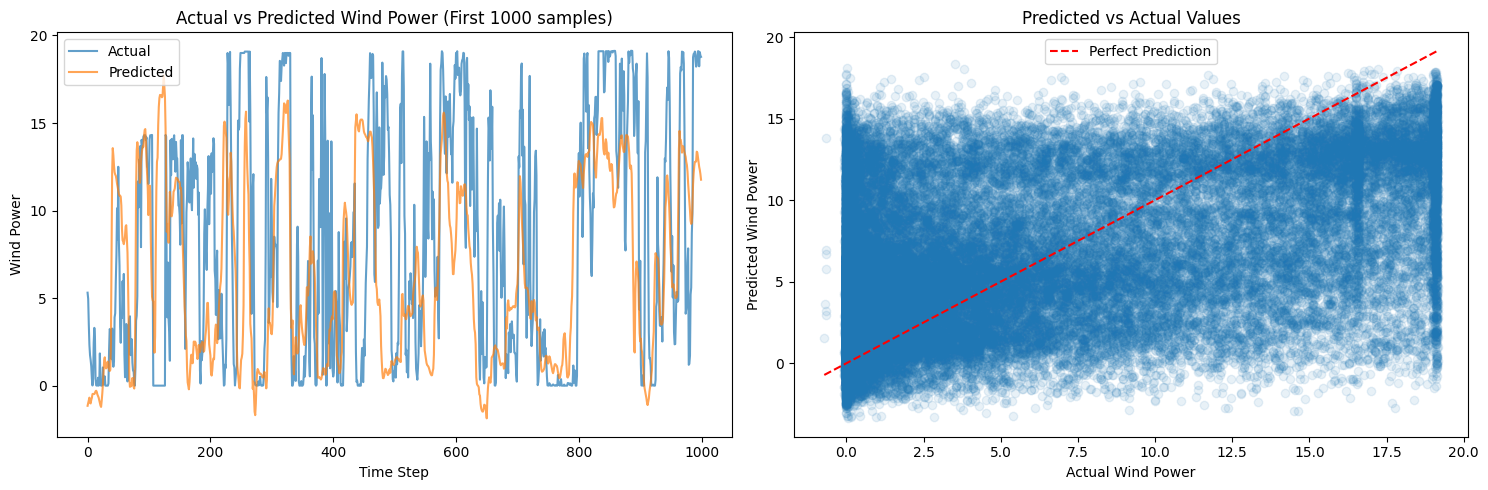


Model Performance on Test Wind Farm:
R² Score: 0.2139
RMSE: 5.6978
MSE: 32.4644

Testing on Camlica Wind Farm:


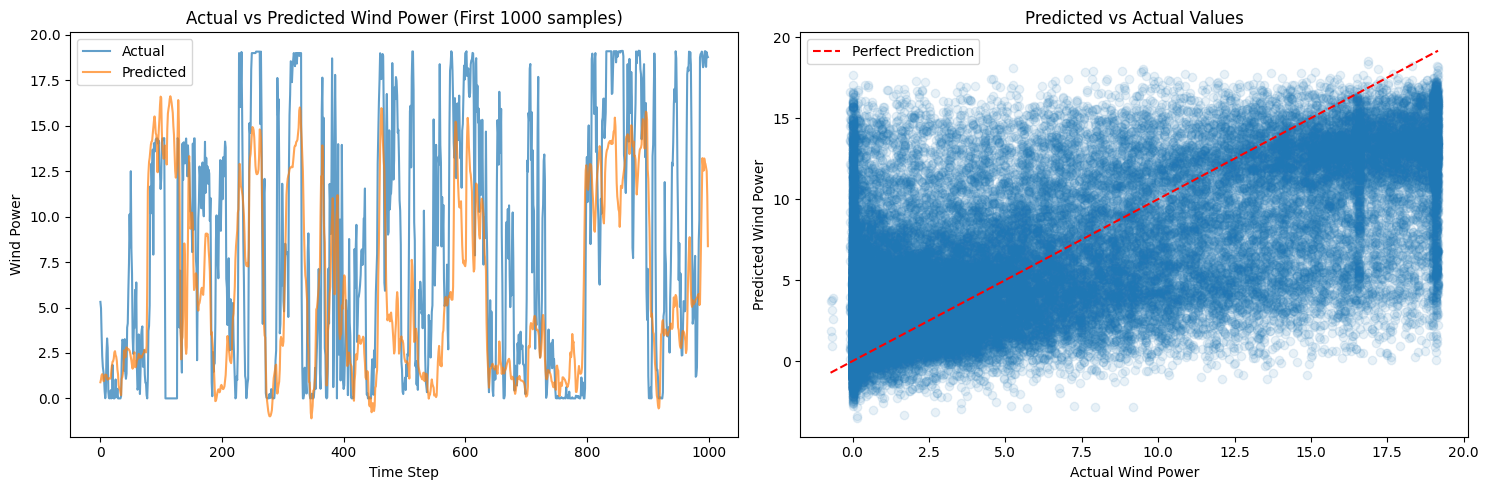


Model Performance on Test Wind Farm:
R² Score: 0.4793
RMSE: 4.6372
MSE: 21.5039

Stage 3: Testing on Newly-established Wind Farm (Bursa)


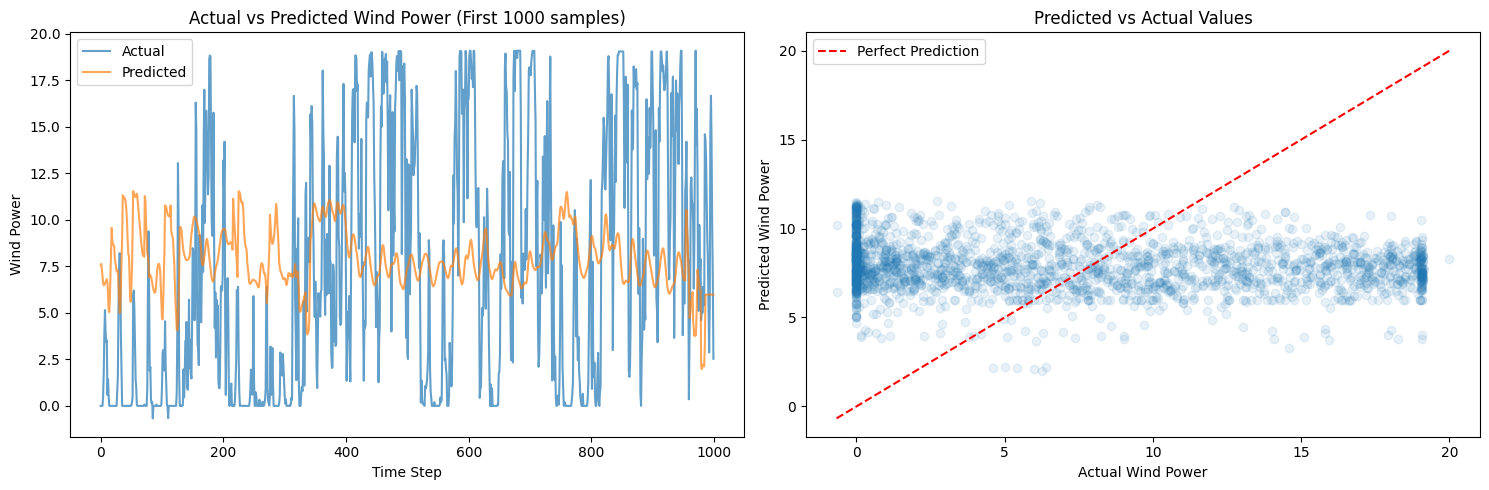


Model Performance on Test Wind Farm:
R² Score: -0.1066
RMSE: 6.7993
MSE: 46.2303


In [ ]:
# Let's evaluate our model
# metrics = evaluate_model_performance(model, val_gen, target_scaler, num_samples=1000)

# let's evaluate trained model
results = complete_wind_power_evaluation()